## Imports

In [1]:
import os

%load_ext autoreload
%autoreload 2
# %load_ext nb_black

In [2]:
!pip3 install timm

     |████████████████████████████████| 376 kB 286 kB/s            


In [3]:
import timm

timm.__version__

'0.4.12'

In [4]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import numpy as np

import time
import random
from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

import cv2
import PIL.Image
import albumentations

import gc

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

%matplotlib inline

import math
import glob

from warnings import filterwarnings

filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
albumentations.__version__

'1.1.0'

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Setting all seeds to be {seed}.")


seed_everything(1337)

Setting all seeds to be 1337.


## Configuration

In [8]:
image_size = 256
batch_size = 80
n_worker = 5
init_lr = 3e-4  # / 3  # 3e-5
n_epochs = 20
fold_id = 1
debug = False  # set this to False to train in full
kernel_type = "resnet18_first_try"
model_dir = "weights/"
train_data_dir = "/kaggle/input/animals-classification/animals/animals/train/"
test_data_dir = "/kaggle/input/animals-classification/animals/animals/test/"

!mkdir $model_dir

In [9]:
dirs = os.listdir(train_data_dir)

In [10]:
dirs

['spider',
 'horse',
 'butterfly',
 'dog',
 'chicken',
 'elephant',
 'sheep',
 'cow',
 'squirrel',
 'cat']

In [11]:
all_files = list()
all_labels = list()
for label in dirs:
    files = os.listdir(train_data_dir + label)
    files = [os.path.join(train_data_dir, label, f) for f in files]
    labels = [label] * len(files)
    all_files.extend(files)
    all_labels.extend(labels)

df_train = pd.DataFrame()
df_train["path"] = all_files
df_train["label"] = all_labels

df_train = df_train.sample(frac=1, random_state=1337)
df_train = df_train.reset_index(drop=True)
df_train.head()

,path,label
0,/kaggle/input/animals-classification/animals/a...,dog
1,/kaggle/input/animals-classification/animals/a...,chicken
2,/kaggle/input/animals-classification/animals/a...,spider
3,/kaggle/input/animals-classification/animals/a...,chicken
4,/kaggle/input/animals-classification/animals/a...,butterfly


In [12]:
test_files = [os.path.join(test_data_dir, f) for f in os.listdir(test_data_dir)]

df_test = pd.DataFrame()
df_test["path"] = test_files
df_test.head()

,path
0,/kaggle/input/animals-classification/animals/a...
1,/kaggle/input/animals-classification/animals/a...
2,/kaggle/input/animals-classification/animals/a...
3,/kaggle/input/animals-classification/animals/a...
4,/kaggle/input/animals-classification/animals/a...


In [13]:
len(df_train), len(df_test)

(10468, 15711)

In [14]:
df_train["label"].nunique()

10

## Make Folds

In [15]:
kf = StratifiedKFold(n_splits=5)
df_train["fold"] = -1
for fold, (train_idx, valid_idx) in enumerate(kf.split(df_train, df_train["label"])):
    df_train.loc[valid_idx, "fold"] = fold

In [16]:
df_train.head()

,path,label,fold
0,/kaggle/input/animals-classification/animals/a...,dog,0
1,/kaggle/input/animals-classification/animals/a...,chicken,0
2,/kaggle/input/animals-classification/animals/a...,spider,0
3,/kaggle/input/animals-classification/animals/a...,chicken,0
4,/kaggle/input/animals-classification/animals/a...,butterfly,0


In [17]:
le = LabelEncoder()
df_train["label"] = le.fit_transform(df_train["label"])

## Transforms

In [18]:
transforms_train = albumentations.Compose(
    [
        albumentations.Resize(image_size, image_size),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.RandomBrightnessContrast(
            p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)
        ),
        albumentations.HueSaturationValue(
            p=0.5, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2
        ),
        albumentations.ShiftScaleRotate(
            p=0.5, shift_limit=0.0625, scale_limit=0.2, rotate_limit=20
        ),
        albumentations.CoarseDropout(p=0.5),
        albumentations.Normalize(),
    ]
)

transforms_valid = albumentations.Compose(
    [albumentations.Resize(image_size, image_size), albumentations.Normalize()]
)

## Dataset

In [19]:
class AnimalDataset(Dataset):
    def __init__(self, df, mode, transform=None):

        self.df = df.reset_index(drop=True)
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.loc[index]
        img = cv2.imread(row["path"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            res = self.transform(image=img)
            img = res["image"]

        img = img.astype(np.float32)
        img = img.transpose(2, 0, 1)

        if self.mode == "test":
            return torch.tensor(img).float()
        else:
            return torch.tensor(img).float(), torch.tensor(row["label"]).float()

2


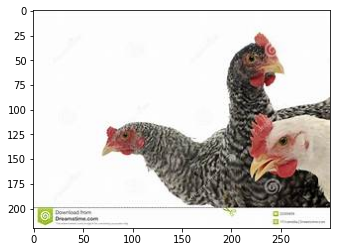

4


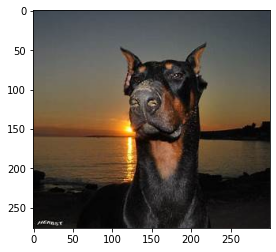

9


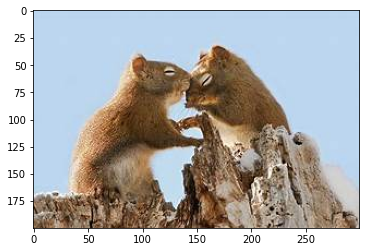

In [20]:
idx_to_show = [1, 100, 1000]
for idx in idx_to_show:
    label = df_train['label'][idx]
    print(label)
    img = cv2.imread(df_train['path'][idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

## Model

In [21]:
mod = "resnet101d"
backbone = timm.create_model(mod, pretrained=False, num_classes=0)
o = backbone(torch.randn(2, 3, image_size, image_size))

del backbone
torch.cuda.empty_cache()
gc.collect()

in_features = o.shape[1]
in_features

2048

In [22]:
class AnimalNet(nn.Module):
    def __init__(
        self,
        dropout_p=0.5,
        num_labels=10,
        backbone="resnet101d",
        pretrained=True,
        in_features=None,
    ):
        super(AnimalNet, self).__init__()
        self.dropout_p = dropout_p
        self.num_labels = num_labels

        self.backbone = timm.create_model(
            backbone, pretrained=pretrained, num_classes=0
        )

        # Freeze all backbone's layers (try to experiment with this)
#         for param in self.backbone.parameters():
#             param.requires_grad = False

        if in_features is None:
            self.in_features = self.backbone.classifier.in_features
        else:
            self.in_features = in_features

        self.dropout = nn.Dropout(p=self.dropout_p, inplace=True)
        self.fc1 = nn.Linear(self.in_features, self.num_labels)

    def forward(self, x):
        features = self.backbone(x)
        features = self.dropout(features)
        #         features = features.view(features.size(0), -1)
        features = self.fc1(features)
        return features

In [23]:
df_train_this = df_train[df_train["fold"] != fold_id]
df_valid_this = df_train[df_train["fold"] == fold_id]

In [24]:
dataset_train = AnimalDataset(df_train_this, "train", transform=transforms_train)
dataset_valid = AnimalDataset(df_valid_this, "valid", transform=transforms_valid)
dataset_test = AnimalDataset(df_test, "test", transform=transforms_valid)

train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_worker,
    drop_last=False,
)
valid_loader = torch.utils.data.DataLoader(
    dataset_valid, batch_size=batch_size, shuffle=False, num_workers=n_worker
)
test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False, num_workers=n_worker
)

In [25]:
model = AnimalNet(
    num_labels=df_train["label"].nunique(),
    backbone=mod,
    in_features=in_features,
)
model.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet101d_ra2-2803ffab.pth" to /root/.cache/torch/hub/checkpoints/resnet101d_ra2-2803ffab.pth


AnimalNet(
  (backbone): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=init_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

## Utils

In [27]:
def train_func(model, train_loader):
    model.train()
    bar = tqdm(train_loader)

    losses_list = list()
    for batch_idx, (images, targets) in enumerate(bar):

        images, targets = images.to(device), targets.to(device).long()

        if debug and batch_idx == 100:
            print("Debug Mode. Only train on first 100 batches.")
            break

        logits = model(images)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses_list.append(loss.item())

        bar.set_description(f"loss_train: {loss.item():.5f}")

    loss_train = np.mean(losses_list)
    print("loss_train:", loss_train)
    return loss_train


def valid_func(model, valid_loader):
    model.eval()
    bar = tqdm(valid_loader)

    targets_list = list()
    losses_list = list()
    preds_list = list()

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(bar):

            images, targets = images.to(device), targets.to(device).long()

            logits = model(images)

            preds_list += [torch.argmax(logits, 1).detach().cpu()]
            targets_list += [targets.detach().cpu()]

            loss = criterion(logits, targets)
            losses_list.append(loss.item())

            bar.set_description(f"loss_valid: {loss.item():.5f}")

    preds_list = torch.cat(preds_list).cpu().numpy()
    targets_list = torch.cat(targets_list).cpu().numpy()
    accuracy = (preds_list == targets_list).mean()

    loss_valid = np.mean(losses_list)
    return loss_valid, accuracy


def test_func(model, test_loader):
    model.eval()
    bar = tqdm(test_loader)

    preds_list = list()

    with torch.no_grad():
        for batch_idx, images in enumerate(bar):

            images = images.to(device)
            logits = model(images)
            preds_list += [torch.argmax(logits, 1).detach().cpu()]
    preds_list = torch.cat(preds_list).cpu().numpy()
    return preds_list

## Train

In [28]:
%%time

for epoch in tqdm(range(n_epochs), desc="epochs"):

    print(f"Epoch {epoch + 1} started")
    torch.cuda.empty_cache()

    print("LR:", optimizer.state_dict()["param_groups"][0]["lr"])
    loss_train = train_func(model, train_loader)
    scheduler.step()
    
    loss_valid, accuracy = valid_func(model, valid_loader)
    print('valid accuracy:', accuracy)
    
    torch.save(
        model.state_dict(),
        f"{model_dir}{kernel_type}_fold{fold_id}_epoch{epoch + 1}.pth",
    )

    print("Checkpoint saved!")
    print()
    print("*" * 90)
    print()

del model
torch.cuda.empty_cache()
gc.collect()

epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 started
LR: 0.0003


  0%|          | 0/105 [00:00<?, ?it/s]

loss_train: 0.3149937750594247


  0%|          | 0/27 [00:00<?, ?it/s]

valid accuracy: 0.9765998089780324
Checkpoint saved!

******************************************************************************************

Epoch 2 started
LR: 0.00029815325108927063


  0%|          | 0/105 [00:00<?, ?it/s]

loss_train: 0.07141064364640486


  0%|          | 0/27 [00:00<?, ?it/s]

valid accuracy: 0.9799426934097422
Checkpoint saved!

******************************************************************************************

Epoch 3 started
LR: 0.00029265847744427303


  0%|          | 0/105 [00:00<?, ?it/s]

loss_train: 0.0398535891347343


  0%|          | 0/27 [00:00<?, ?it/s]

valid accuracy: 0.9813753581661891
Checkpoint saved!

******************************************************************************************

Epoch 4 started
LR: 0.0002836509786282552


  0%|          | 0/105 [00:00<?, ?it/s]

loss_train: 0.03601303793756025


  0%|          | 0/27 [00:00<?, ?it/s]

valid accuracy: 0.9770773638968482
Checkpoint saved!

******************************************************************************************

Epoch 5 started
LR: 0.0002713525491562421


  0%|          | 0/105 [00:00<?, ?it/s]

loss_train: 0.02705957555832962


  0%|          | 0/27 [00:00<?, ?it/s]

valid accuracy: 0.9785100286532952
Checkpoint saved!

******************************************************************************************

Epoch 6 started
LR: 0.0002560660171779821


  0%|          | 0/105 [00:00<?, ?it/s]

loss_train: 0.024217041275863136


  0%|          | 0/27 [00:00<?, ?it/s]

valid accuracy: 0.9680038204393505
Checkpoint saved!

******************************************************************************************

Epoch 7 started
LR: 0.000238167787843871


  0%|          | 0/105 [00:00<?, ?it/s]

loss_train: 0.01760597103940589


  0%|          | 0/27 [00:00<?, ?it/s]

valid accuracy: 0.9765998089780324
Checkpoint saved!

******************************************************************************************

Epoch 8 started
LR: 0.00021809857496093204


  0%|          | 0/105 [00:00<?, ?it/s]

loss_train: 0.018336604472382792


  0%|          | 0/27 [00:00<?, ?it/s]

valid accuracy: 0.9823304680038204
Checkpoint saved!

******************************************************************************************

Epoch 9 started
LR: 0.00019635254915624216


  0%|          | 0/105 [00:00<?, ?it/s]

loss_train: 0.00893489078929027


  0%|          | 0/27 [00:00<?, ?it/s]

valid accuracy: 0.9789875835721108
Checkpoint saved!

******************************************************************************************

Epoch 10 started
LR: 0.00017346516975603468


  0%|          | 0/105 [00:00<?, ?it/s]

loss_train: 0.003994955030308726


  0%|          | 0/27 [00:00<?, ?it/s]

valid accuracy: 0.9842406876790831
Checkpoint saved!

******************************************************************************************

Epoch 11 started
LR: 0.00015000000000000001


  0%|          | 0/105 [00:00<?, ?it/s]

loss_train: 0.0063810377667236715


  0%|          | 0/27 [00:00<?, ?it/s]

valid accuracy: 0.9818529130850048
Checkpoint saved!

******************************************************************************************

Epoch 12 started
LR: 0.0001265348302439654


  0%|          | 0/105 [00:00<?, ?it/s]

loss_train: 0.004504214697988659


  0%|          | 0/27 [00:00<?, ?it/s]

valid accuracy: 0.9832855778414518
Checkpoint saved!

******************************************************************************************

Epoch 13 started
LR: 0.0001036474508437579


  0%|          | 0/105 [00:00<?, ?it/s]

loss_train: 0.004430526264158765


  0%|          | 0/27 [00:00<?, ?it/s]

valid accuracy: 0.9804202483285578
Checkpoint saved!

******************************************************************************************

Epoch 14 started
LR: 8.190142503906799e-05


  0%|          | 0/105 [00:00<?, ?it/s]

loss_train: 0.004004876119281454


  0%|          | 0/27 [00:00<?, ?it/s]

valid accuracy: 0.9861509073543457
Checkpoint saved!

******************************************************************************************

Epoch 15 started
LR: 6.183221215612905e-05


  0%|          | 0/105 [00:00<?, ?it/s]

loss_train: 0.0025474992772658534


  0%|          | 0/27 [00:00<?, ?it/s]

valid accuracy: 0.9866284622731614
Checkpoint saved!

******************************************************************************************

Epoch 16 started
LR: 4.393398282201788e-05


  0%|          | 0/105 [00:00<?, ?it/s]

loss_train: 0.0016379127317729095


  0%|          | 0/27 [00:00<?, ?it/s]

valid accuracy: 0.9871060171919771
Checkpoint saved!

******************************************************************************************

Epoch 17 started
LR: 2.86474508437579e-05


  0%|          | 0/105 [00:00<?, ?it/s]

loss_train: 0.00123532168079345


  0%|          | 0/27 [00:00<?, ?it/s]

valid accuracy: 0.9847182425978988
Checkpoint saved!

******************************************************************************************

Epoch 18 started
LR: 1.6349021371744834e-05


  0%|          | 0/105 [00:00<?, ?it/s]

loss_train: 0.001222480794829261


  0%|          | 0/27 [00:00<?, ?it/s]

valid accuracy: 0.9866284622731614
Checkpoint saved!

******************************************************************************************

Epoch 19 started
LR: 7.341522555726972e-06


  0%|          | 0/105 [00:00<?, ?it/s]

loss_train: 0.0014767322663655725


  0%|          | 0/27 [00:00<?, ?it/s]

valid accuracy: 0.9871060171919771
Checkpoint saved!

******************************************************************************************

Epoch 20 started
LR: 1.8467489107293517e-06


  0%|          | 0/105 [00:00<?, ?it/s]

loss_train: 0.001016456327730945


  0%|          | 0/27 [00:00<?, ?it/s]

valid accuracy: 0.9866284622731614
Checkpoint saved!

******************************************************************************************

CPU times: user 25min 4s, sys: 13min 15s, total: 38min 20s
Wall time: 43min 10s


90

In [29]:
model = AnimalNet(
    num_labels=df_train["label"].nunique(),
    backbone=mod,
    in_features=in_features,
)

model.load_state_dict(
    torch.load(
        f"{model_dir}{kernel_type}_fold{fold_id}_epoch{epoch + 1}.pth",
    )
)

model.to(device)

AnimalNet(
  (backbone): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [30]:
%%time

preds = test_func(model, test_loader)

  0%|          | 0/197 [00:00<?, ?it/s]

CPU times: user 47.8 s, sys: 4.16 s, total: 52 s
Wall time: 1min 20s


In [31]:
test_files = os.listdir(test_data_dir)

df_preds = pd.DataFrame()
df_preds["path"] = test_files
df_preds["label"] = preds
df_preds["label"] = le.inverse_transform(df_preds["label"])
df_preds.head()

,path,label
0,bmimftuxqdwpjexjpmtt.jpg,cow
1,gittosxmvjvltzyevrji.jpg,dog
2,rozuhiughubdrgnlhldi.jpg,butterfly
3,ezltxoovfnxmrquojdvm.jpg,dog
4,rpxerbmbyatglwszwlyd.jpg,spider


In [32]:
df_preds

,path,label
0,bmimftuxqdwpjexjpmtt.jpg,cow
1,gittosxmvjvltzyevrji.jpg,dog
2,rozuhiughubdrgnlhldi.jpg,butterfly
3,ezltxoovfnxmrquojdvm.jpg,dog
4,rpxerbmbyatglwszwlyd.jpg,spider
...,...,...
15706,phgjcgjupskfjlizhwrq.jpg,butterfly
15707,fhtacdgevohyxibtyloh.jpg,chicken
15708,dclqzdckfaaxlbyqsaxx.jpg,spider
15709,zpybxkhsokwuqtslbyoq.jpg,chicken


In [33]:
df_preds.to_csv("ans_2.csv", index=False)

In [34]:
os.curdir

'.'

#Опа